In [1]:
# Newer attempt to make it quicker
# Get the envelope only on the segments where rms is significant.

# viewing neural data
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.signal import hilbert
from scipy.stats import pearsonr
from scipy.io import wavfile
from scipy.signal import spectrogram
from basic_viewing import h5_functions as h5
import logging

matplotlib.style.use('ggplot')


# Check wihic computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name
if  comp_name == 'chim':
    #sys.path.append('/Users/zeke/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join(os.path.abspath('W:') , "earneodo", "bci_zf")
elif  'lookfar' in comp_name:
    repos_folder = os.path.abspath('/Users/zeke/reposs')
    experiment_folder = os.path.join(os.path.abspath('/Volumes') , 'gentner', 'earneodo', 'bci_zf')

elif 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

elif 'passaro' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'soundflow', 'sound_tools'))
sys.path.append(os.path.join(repos_folder, 'ephysflow'))
sys.path.append(os.path.join(repos_folder, 'analysis-tools'))

import soundtools as st
import Kwik as oe


raw_data_folder = os.path.join(experiment_folder, 'raw_data')
ss_data_folder = os.path.join(experiment_folder, 'ss_data')


#given a chunk that contains a sine wave, find its onset
def peaks(signal, min_height=0):
    np.where(signal[1:-1]>min_height)
    peak_ind = [i for i in np.where(signal[1:-1]>min_height)[0] if signal[i]>signal[i-1] & signal[i]>signal[i+1]]
    return peak_ind

def find_onset_sine(chunk, freq=1000, f_s=30000):
    roof = int(max(chunk)*0.25)
    first_peak = peaks(chunk, min_height=roof)[0]
    
    onset = first_peak - int(f_s/(4.*freq))
    return onset

def envelope(x, window=200):
    analytic_signal = hilbert(x)
    amplitude_envelope = np.abs(analytic_signal)
    w=np.ones(window, 'd')
    return np.convolve(w/w.sum(),amplitude_envelope,mode='valid')

def correlation_with_pattern(data, pattern, window, filter_func, *args, **kwargs):
    segment = envelope(filter_func(data, *args, **kwargs), window=window)
    return pearsonr(segment, pattern)[0]

def apply_repeated(s, starts, window, scalar_func, *args, **kwargs):
    # starts, window in sample units
    y = np.empty_like(starts)
    for i_s, start in enumerate(starts):
        a_chunk = st.Chunk(s, segment=[start, start + window])
        y[i_s] = scalar_func(a_chunk.data, *args, **kwargs)

    return y

def band_pass_filter(x, hp_b, hp_a, lp_b, lp_a):    
    x_hi = sg.filtfilt(hp_b, hp_a, x, axis=0)
    x_filt = sg.filtfilt(lp_b, lp_a, x_hi, axis=0)
    return x_filt

def compare_spectrogram(sxx, pattern_sxx):
    return np.sum(np.abs(pattern_sxx-sxx)/np.sum(np.abs(sxx)))

def spectral_score(chunk, pattern_sxx):
    f, t, Sxx = spectrogram(chunk.data, chunk.sound.s_f, nperseg = n_window, noverlap=n_overlap, 
                        window = sg.gaussian(n_window, sigma), scaling='spectrum')
    assert(Sxx.shape == pattern_sxx.shape)
    return compare_spectrogram(Sxx, pattern_sxx)



Computer: passaro


In [2]:
#file structure
bird_id = 'z020'
sess = 'day-2016-06-02'
rec = 0
run = 1
processor = ''

raw_file_folder = os.path.join(ss_data_folder, bird_id, sess)
raw_file_base_name = 'experiment'

raw_file_name = raw_file_base_name + processor + '.raw.kwd'
evt_file_name = raw_file_base_name + '.kwe'

raw_file_path = os.path.join(raw_file_folder, raw_file_name)
#evt_file_path = os.path.join(raw_file_folder, evt_file_name)

# open the file in read mode
raw_file = h5py.File(raw_file_path, 'r')
#evt_file = h5py.File(evt_file_path, 'r')

# load it with the open-ephys api for version 2 of kiwk format

oe_file = oe.load(raw_file_path)


In [3]:
# list records
raw_file['recordings'].keys()

[u'0', u'1', u'2', u'3', u'4', u'5']

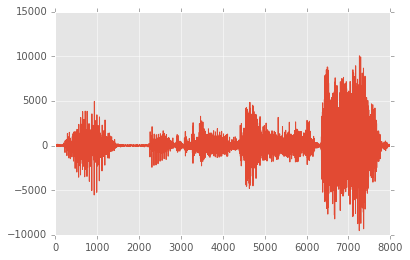

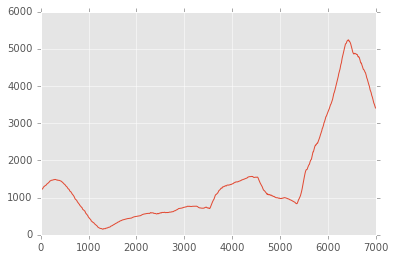

In [3]:
# get the sound and the pattern
chan_name = "CH17"
chan_number = 16
data_table = raw_file['/recordings'][str(rec)]['data']
chan_sf = oe.get_sample_rate(raw_file)
pattern = 1
#filter parameters
filt_lo = 7000 #Hz
filt_hi = 500 #Hz

# sonogram parameters
n_window = 256;
n_overlap = 192;
f_cut = 10000;
sigma = 1./1000.*chan_sf

#template match parameters
window_env = 1000

audio_slice = h5.load_table_slice(data_table, np.arange(0, data_table.shape[0]), [chan_number])
chan_sound = st.DatSoundCompat(st.bandpass_filter(audio_slice[int(3674.214226*30000.) - 1600:
                                                              int(3674.214226*30000.)+ 32000,0], 
                                                  chan_sf, filt_hi, filt_lo), 
                                                  chan_sf, data_type=np.float)
#chan_whole_sound = st.DatSoundCompat(st.bandpass_filter(audio_slice[:,0], chan_sf, filt_hi, filt_lo),
#                                     chan_sf, data_type=np.float)
                               
# # Now try to save a channel as a wav file
# from scipy.io import wavfile
out_file_name = raw_file_base_name +  '_' + chan_name + 'song.wav'
# wavfile.write(os.path.join(raw_file_folder, out_file_name),chan_sf, np.array(chan_sound.stream, dtype='int16'))

#make the filter for the data file
s_f = chan_sf
#The band where we expect most of the energy of zf song to be in
hp_b, hp_a = sg.butter(4, filt_hi/(s_f/2.), btype='high')
lp_b, lp_a = sg.butter(4, filt_lo/(s_f/2.), btype='low')

# read a bout from a wave file and prepare the templates 
pattern_name = 'motiff_' + str(pattern) + '.wav'
pattern_path = os.path.join(raw_file_folder, pattern_name)

pattern_sound = st.WavData2(pattern_path)
pattern_chunk = st.Chunk(pattern_sound)
pattern_chunk.apply_filter(st.bandpass_filter, s_f)
plt.plot((pattern_chunk.data))
pattern_envelope = st.envelope(pattern_chunk.data[:,0], window=window_env)
plt.figure()
plt.plot(pattern_envelope)
pattern_spectrogram = spectrogram(pattern_chunk.data[:,0], s_f, nperseg = n_window, noverlap=n_overlap, 
                        window = sg.gaussian(n_window, sigma), scaling='spectrum')
plt.figure()


In [70]:
# try to get the template matches from soundtools functions
import threading
from IPython.display import display

class chunkFunction():
    def __init__(self, chunk, function, *args, **kwargs):
        print args
        self.chunk = chunk
        self.func = function
        self.args = args
        self.kwargs = kwargs

    def start(self):
        display('Starting function {0}'.format(self.func.func_name))
        for arg in self.args:
            print arg
        for key, arg in self.kwargs.iteritems():
            print key
            print arg
        self.chunk.apply_filter(self.func, *self.args, **self.kwargs)
        print "done"

class threadFunction():
    def __init__(self, function, *args, **kwargs):
        self.func = function
        self.args = args
        self.kwargs = kwargs
        self.out = None

    def run(self):
        display('Starting function {0}'.format(self.func.func_name))
        for arg in self.args:
            print arg
        for key, arg in self.kwargs.iteritems():
            print key
            print arg
        self.out = self.func(*self.args, **self.kwargs)
        print "done"

In [225]:
# create logger with 'spam_application'
logger = logging.getLogger('searching_motiff_nopandas')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler('search_motiff-v2-nopandas.log')
fh.setLevel(logging.DEBUG)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
import scipy.stats as ss
envelope = st.envelope
find_peaks = st.find_peaks
Chunk = st.Chunk

def rms(x):
    return np.linalg.norm(x)

def get_rms_threshold(full_sound, window_size_samples, rms_threshold_factor):
    all_starts = np.arange(0, full_sound.n_samples - window_size_samples, window_size_samples)
    all_rms = full_sound.apply_repeated(all_starts, window_size_samples, rms)
    thresh_rms = np.mean(all_rms) + rms_threshold_factor * np.std(all_rms)
    return thresh_rms
    
def envelope_correlation(x, template_env, window=200, rms_thresh=None):
    if x.ndim>1:
        x=x[0,:]
    if (rms_thresh is not None) and rms(x) < rms_thresh:
        scalar_corr = 0
    else:
        scalar_corr = ss.pearsonr(envelope(x, window=window), template_env)[0]
    return scalar_corr

def match_by_envelope(full_sound, pattern, window_size=500, corr_thresh=0.85, rms_threshold=None, window_step=1):
    """
    :param full_sound: Sound with the full sound
    :param pattern: Chunk with the pattern to find
    :param window_size: size of window for the envelope
    :param corr_thresh: threshold for peaks of correlation
    :param rms_threshold: threshold for rms (in standard deviations)
    :return:
    """
    logger.info('Matching envelope across sound with {0} samples'.format(full_sound.n_samples))
    s_f = full_sound.s_f
    full_chunk = Chunk(full_sound)
    
    if rms_threshold is not None:
        logger.info('Getting rms threshold with {} std'.format(rms_threshold))
        min_rms = get_rms_threshold(full_sound, pattern.samples, rms_threshold)
        logger.info('Correlation threshold set to {}'.format(min_rms))
    else:
        min_rms = None
        
    match_points = find_envelope(full_sound, (pattern.data[:,0]),
                                 corr_thresh=corr_thresh, 
                                 window_size=window_size, 
                                 min_rms=min_rms,
                                 window_step=window_step)
    
    logger.debug('Returning match_points')
    return match_points

def find_envelope(full_sound, pattern, corr_thresh=0., window_size=500, min_rms=0, window_step=1):
    """
    :param stream: 0xN array
    :param pattern: 0xN array
    :param corr_thresh:
    :param window_size:
    :param min_rms: minimum value of rms for the window to compute envelope
    :return:
    """
    logger.info('Env has {} samples'.format(full_sound.n_samples))
    logger.info('Rolling correlation with envelope...')
    pattern_env = envelope(pattern, window=window_size)
    logger.info(pattern_env.shape)
    
    all_starts = np.arange(0, full_sound.n_samples - pattern.size, window_step)
    all_corr = full_sound.apply_repeated(all_starts, pattern.size,
                                        envelope_correlation,
                                       pattern_env,
                                       window_size, None)
    
    logger.info('Found {} segments above correlation threshold'.format(all_corr.size))
    # find the peaks semi-naively
    max_pos = find_peaks(all_corr,
                         threshold=corr_thresh,
                         min_peak_distance=int(pattern.size/window_step)-1,
                         filter_method='ranked')

    logger.info('Found {0} peaks'.format(max_pos.shape[0]))
    return {'corr': all_corr, 'peaks': max_pos}

#pk = match_by_envelope(chan_sound, pattern_chunk, rms_threshold=0.5, window_step=30)

2016-07-07 00:08:35,155 - searching_motiff_nopandas - INFO - Matching envelope across sound with 32000 samples
2016-07-07 00:08:35,155 - searching_motiff_nopandas - INFO - Matching envelope across sound with 32000 samples
2016-07-07 00:08:35,155 - searching_motiff_nopandas - INFO - Matching envelope across sound with 32000 samples
2016-07-07 00:08:35,155 - searching_motiff_nopandas - INFO - Matching envelope across sound with 32000 samples
2016-07-07 00:08:35,155 - searching_motiff_nopandas - INFO - Matching envelope across sound with 32000 samples
2016-07-07 00:08:35,155 - searching_motiff_nopandas - INFO - Matching envelope across sound with 32000 samples
2016-07-07 00:08:35,155 - searching_motiff_nopandas - INFO - Matching envelope across sound with 32000 samples
2016-07-07 00:08:35,155 - searching_motiff_nopandas - INFO - Matching envelope across sound with 32000 samples
2016-07-07 00:08:35,155 - searching_motiff_nopandas - INFO - Matching envelope across sound with 32000 samples
2

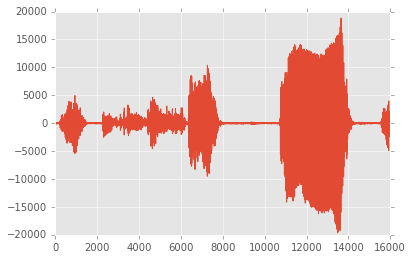

In [224]:
start = 16039
plt.plot(chan_sound.stream[0,start:start+16000])

In [226]:
pk

{'corr': array([ -1.50619896e-01,  -1.48785784e-01,  -1.46167424e-01,
         -1.42790147e-01,  -1.38696121e-01,  -1.33940104e-01,
         -1.28574152e-01,  -1.22596088e-01,  -1.16056838e-01,
         -1.09027846e-01,  -1.01608494e-01,  -9.38970194e-02,
         -8.59260190e-02,  -7.77934607e-02,  -6.95756678e-02,
         -6.13970340e-02,  -5.33967169e-02,  -4.57031118e-02,
         -3.84737856e-02,  -3.18515008e-02,  -2.59693546e-02,
         -2.08788084e-02,  -1.66652081e-02,  -1.33769404e-02,
         -1.11782157e-02,  -1.01089563e-02,  -1.01590830e-02,
         -1.12038741e-02,  -1.32343456e-02,  -1.61687083e-02,
         -1.99370436e-02,  -2.44194762e-02,  -2.94024563e-02,
         -3.45569173e-02,  -3.96337515e-02,  -4.43173474e-02,
         -4.83006137e-02,  -5.11854917e-02,  -5.27074212e-02,
         -5.25548847e-02,  -5.03868504e-02,  -4.61863314e-02,
         -3.94625968e-02,  -3.04026738e-02,  -1.89456471e-02,
         -5.31718156e-03,   1.06870183e-02,   2.86485172e-02,


In [232]:
start = 535*30
segment = (chan_sound.stream[:,start:start+8000])
spectrogram_diff(segment, pattern_spectrogram[2], s_f, spectrogram_kwargs)

0.13079429862440972

In [211]:
start = 16020 + 10
segment = st.bandpass_filter(np.transpose(chan_sound.stream[:,start:start+8000]),s_f, 500, 10000)
spectrogram_diff(np.transpose(segment), pattern_spectrogram[2], s_f, spectrogram_kwargs)

0.30049098414048464

In [233]:
def spectrogram_diff(data, pattern_sxx, s_f, spectrogram_kwargs):
    f, t, Sxx = spectrogram(data[0,:], s_f, **spectrogram_kwargs)
    assert(Sxx.shape == pattern_sxx.shape)
    return compare_spectrogram(np.log(Sxx), np.log(pattern_sxx))

def spectrogram_scores(pattern_chunk, chan_sound, candidates):
    s_f = chan_sound.s_f
    n_window = 256
    n_overlap = 192
    f_cut = 10000
    sigma = 1. / 1000. * s_f

    spectrogram_kwargs = {'nperseg': n_window,
                        'noverlap': n_overlap,
                        'window': sg.gaussian(n_window, sigma),
                        'scaling': 'spectrum'}

    pattern_spectrogram = spectrogram(pattern_chunk.data[:,0], s_f, **spectrogram_kwargs)

    logger.info('Getting spectrogram difference score for {} candidates'.format(len(candidates.index)))
    for (i, start) in enumerate(candidates['start'][:]):
        #logger.debug('Start {0}: {1}'.format(i, start))
        motif_start = start
        series = chan_sound.get_chunk(motif_start, motif_start + pattern_chunk.samples)
        #f, t, sxx = spectrogram(bandpass_filter(series[:, 0], s_f), s_f, **spectrogram_kwargs)

        candidates.set_value(i, 'spectral_diff',
                             spectrogram_diff(series,
                                              pattern_spectrogram[2],
                                              s_f,
                                              spectrogram_kwargs)
                             )
        #plt.figure()
        #plt.pcolormesh(t, f[f < f_cut], np.log(sxx[f < f_cut, :]))

def find_happy_song(chan_sound, pattern_chunk):
    window_env = 500
    rms_thresh = 1.5
    onset_resolution = 30
    logger.info('Begin to search')
    envelope_matches = match_by_envelope(chan_sound, pattern_chunk, 
                                         window_size=window_env, 
                                         rms_threshold=rms_thresh,
                                         window_step=onset_resolution)
    
    candidates = pd.DataFrame({'start' : (envelope_matches['peaks'] + 1) * onset_resolution,
                           'env_corr': envelope_matches['corr'][envelope_matches['peaks']],
                           'spectral_diff': np.zeros_like(envelope_matches['peaks'], dtype=np.float)})
    
    n_candidates = len(candidates.index)
    logger.info('Found {0} candidates'.format(n_candidates))
    
    if n_candidates > 0:
        logger.info('Getting spectrogram scores')
        spectrogram_scores(pattern_chunk, chan_sound, candidates)
        if n_candidates > 2:
            logger.info('Clustering candidates')
            st.cluster_spectrograms(candidates)
    else:
        pass
    logger.debug('Returning clustered candidates')
    return candidates

chan_whole_sound = st.DatSoundCompat(st.bandpass_filter(audio_slice[:,0], chan_sf, filt_hi, filt_lo),
                                     chan_sf, data_type=np.float)
# chan_sound = st.DatSoundCompat(st.bandpass_filter(audio_slice[int(3674.214226*30000.) - 16000:
#                                                               int(3674.214226*30000.) + 80000,0], chan_sf, 400, 10000), 
#                                                   chan_sf, data_type=np.float)
task_find_happy_song = threadFunction(find_happy_song, chan_whole_sound, pattern_chunk)

threads = []
t = threading.Thread(name= 'task_find_happy_song', 
                     target=task_find_happy_song.run)
threads.append(t)
t.start()

'Starting function find_happy_song'

2016-07-07 00:12:53,898 - searching_motiff_nopandas - INFO - Begin to search


<soundtools.DatSoundCompat instance at 0x7fc2052aa5f0>
<soundtools.Chunk instance at 0x7fc25c2d9f38>


2016-07-07 00:12:53,898 - searching_motiff_nopandas - INFO - Begin to search
2016-07-07 00:12:53,898 - searching_motiff_nopandas - INFO - Begin to search
2016-07-07 00:12:53,898 - searching_motiff_nopandas - INFO - Begin to search
2016-07-07 00:12:53,898 - searching_motiff_nopandas - INFO - Begin to search
2016-07-07 00:12:53,898 - searching_motiff_nopandas - INFO - Begin to search
2016-07-07 00:12:53,898 - searching_motiff_nopandas - INFO - Begin to search
2016-07-07 00:12:53,898 - searching_motiff_nopandas - INFO - Begin to search
2016-07-07 00:12:53,898 - searching_motiff_nopandas - INFO - Begin to search
2016-07-07 00:12:53,898 - searching_motiff_nopandas - INFO - Begin to search
2016-07-07 00:12:53,898 - searching_motiff_nopandas - INFO - Begin to search
2016-07-07 00:12:53,910 - searching_motiff_nopandas - INFO - Matching envelope across sound with 215928000 samples
2016-07-07 00:12:53,910 - searching_motiff_nopandas - INFO - Matching envelope across sound with 215928000 samples


In [4]:
t.isAlive()

NameError: name 't' is not defined

In [240]:
all_candidates

,index,env_corr,spectral_diff,start,bout,rms
0,0,0.998952,0.135159,110226480,True,144274.428286
1,1,0.989129,0.184147,163212720,True,157639.516706
2,2,0.980179,0.201975,163273530,True,176726.400265
3,3,0.971985,0.196630,163242900,True,206282.046343
4,4,0.971000,0.222583,163288050,True,214329.668280
5,5,0.969114,0.215890,163303650,True,201676.773403
6,6,0.968108,0.198668,110295180,True,162705.093522
7,7,0.968092,0.190835,110253060,True,157357.255118
8,8,0.967128,0.208976,163258170,True,184609.674911
9,9,0.966547,0.203709,163227750,True,209971.026483


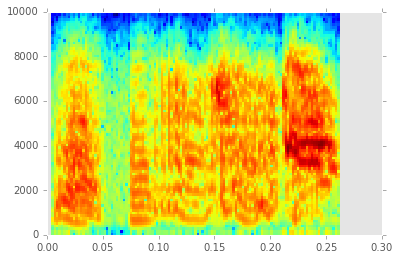

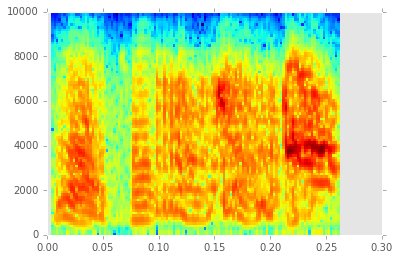

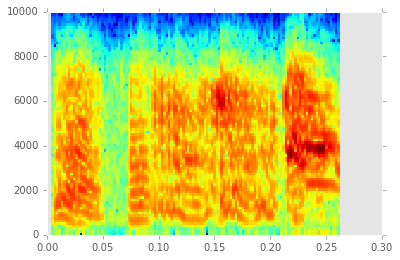

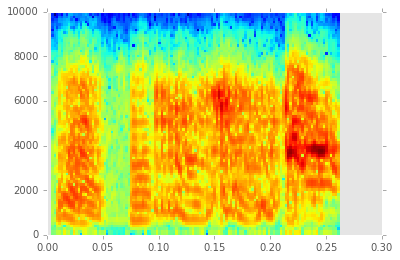

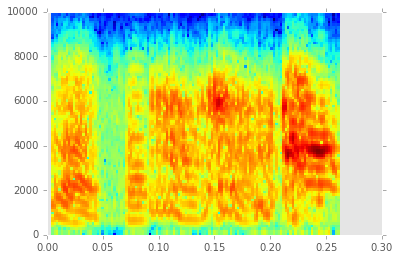

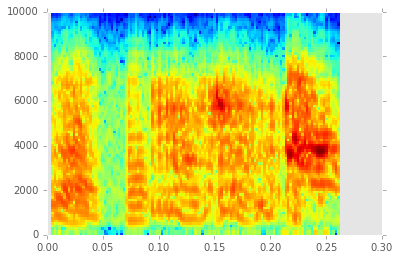

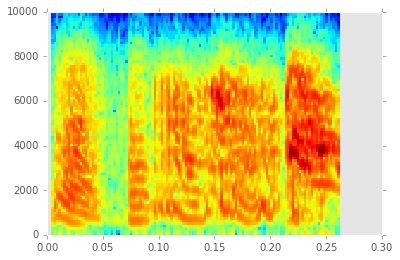

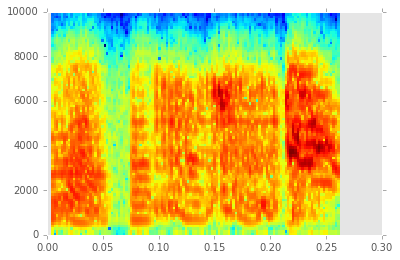

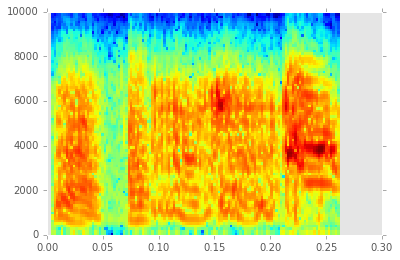

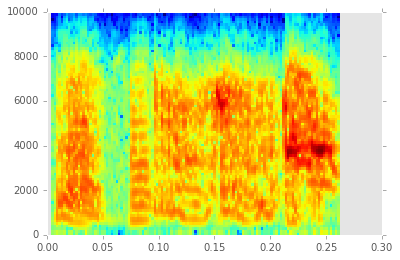

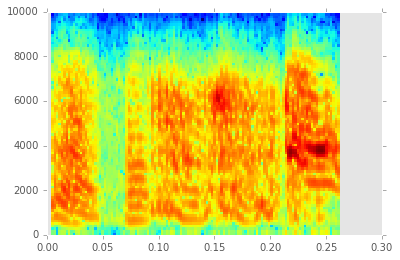

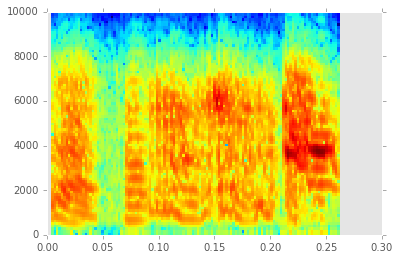

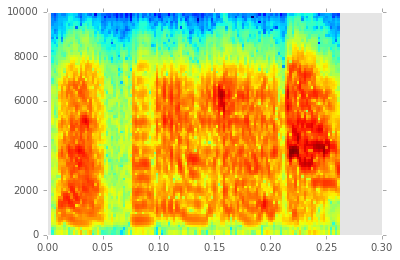

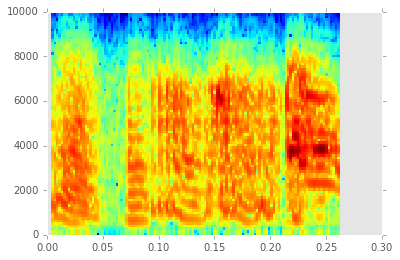

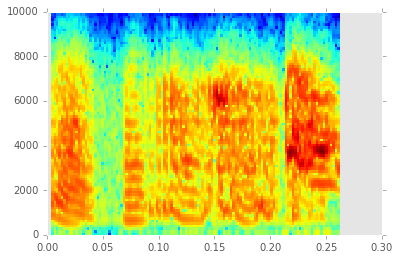

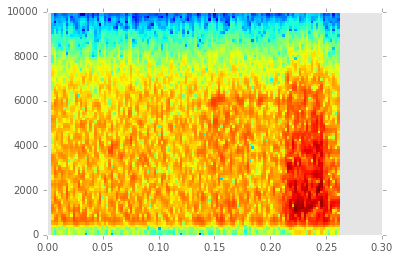

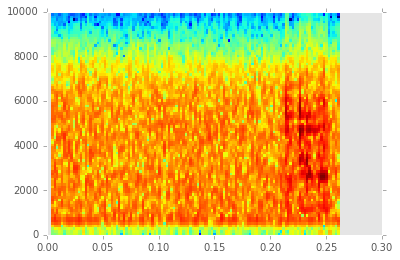

In [243]:
spectrogram_kwargs = {'nperseg': n_window,
                    'noverlap': n_overlap,
                    'window': sg.gaussian(n_window, sigma),
                    'scaling': 'spectrum'}

result = task_find_happy_song.out
all_candidates = result[result['bout']==True].sort_values('spectral_diff').reset_index()
all_candidates = result
rms_thresh = 53057.638761;

for (i, start) in enumerate(all_candidates['start'][:17]):
    motif_start = start
    #print all_candidates[i]
    series = chan_whole_sound.get_chunk(motif_start, motif_start + pattern_chunk.samples)
    # get the histogram
    f, t, sxx = spectrogram(series[0, :], s_f, **spectrogram_kwargs)
    # get the rms
    #print rms(st.bandpass_filter(series[:, 0], s_f))
    all_candidates.set_value(i, 'rms', rms(st.bandpass_filter(series[0,:], s_f)))
    plt.figure()
    plt.pcolormesh(t, f[f < f_cut], np.log(sxx[f < f_cut, :]))

all_candidates = all_candidates[all_candidates['rms'] > rms_thresh].reset_index()

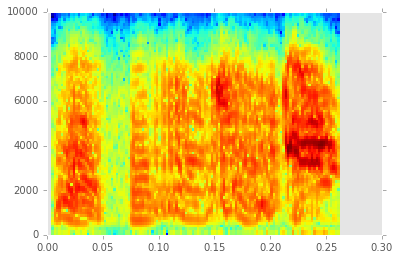

In [11]:
s_f = chan_sound.s_f
n_window = 256;
n_overlap = 192;
f_cut = 10000;
sigma = 1. / 1000. * s_f
spectrogram_pars = {'nperseg': n_window, 
                    'noverlap': n_overlap, 
                    'window': sg.gaussian(n_window, sigma),
                    'scaling': 'spectrum'}

f, t, sxx_pattern = st.spectrogram(pattern_chunk.data[:,0], s_f, **spectrogram_pars)

plt.pcolormesh(t, f[f<f_cut], np.log(sxx_pattern[f<f_cut, :]))